In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [6]:
seed = 1

In [7]:
movies_csv = pd.read_csv("./data/movies.csv", index_col='movieId')
genres = movies_csv.genres.str.get_dummies(sep='|').astype(bool).drop(['(no genres listed)'], axis=1)
movies = movies_csv.drop(['title', 'genres'], axis=1).join(genres)
movies.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
1,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False
5,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [8]:
ratings_csv = pd.read_csv("./data/ratings.csv", index_col=['userId', 'movieId'])
ratings = ratings_csv.drop('timestamp', axis=1)
ratings.head()

rating
userId movieId        
1      31          2.5
       1029        3.0
       1061        3.0
       1129        2.0
       1172        4.0

In [9]:
class Model:
    def train(self, train_data):
        ...
    def predict(self, predict_index):
        result = pd.DataFrame(predict_index.apply(self.get_rating, axis = 1), columns=['prediction'])
        result.index = pd.MultiIndex.from_frame(predict_index)
        return result
    def get_rating(self, id):
        ...

In [10]:
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
evaluation_sample = ratings.sample(frac=1, random_state=seed)

def evaluate(model, print_folds=False, print_sample=False):
    scores = []
    for i, (train_index, test_index) in enumerate(kf.split(evaluation_sample), start=1):
        train_data = ratings.iloc[train_index]
        test_data = ratings.iloc[test_index]

        model.train(train_data)
        predict_index = test_data.drop('rating', axis=1).reset_index()
        predictions = model.predict(predict_index)
        mae = mean_absolute_error(test_data['rating'], predictions)
        scores.append(mae)
        if print_folds:
            print("Fold no.", i)
            if print_sample:
                print("Prediction sample:\n", test_data.join(predictions).sample(n=5, random_state=seed))
            print("MAE score:", mae)
            print()
    print("Mean MAE score:", np.mean(scores))

In [11]:
class GlobalMean(Model):
    def train(self, train_data):
        self.mean = train_data.rating.mean()
    def get_rating(self, id):
        return self.mean
    
evaluate(GlobalMean())

Mean MAE score: 0.8498061887002397


In [12]:
class MovieMean(GlobalMean):
    def train(self, train_data):
        super().train(train_data)
        self.mean_movies = train_data.groupby('movieId').mean()
    
    def get_rating(self, id):
        result = self.mean_movies['rating'].get(id.movieId)
        if result is None:
            result =  super().get_rating(id)
        return result


evaluate(MovieMean())

Mean MAE score: 0.7709324791629936


In [13]:
class UserMean(MovieMean):
    def train(self, train_data):
        super().train(train_data)
        self.mean_users = train_data.groupby('userId').mean()
    
    def get_rating(self, id):
        result = self.mean_users['rating'].get(id.userId)
        if result is None:
            result =  super().get_rating(id)
        return result


evaluate(UserMean())

Mean MAE score: 0.7500415782537506


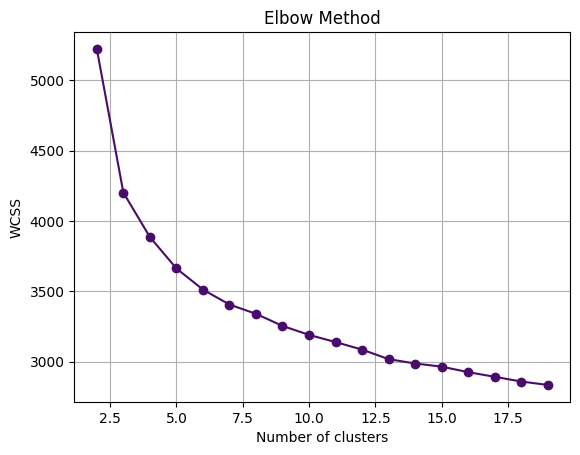

In [16]:
genre_user_matrix = ratings.join(movies).melt(id_vars='rating', ignore_index=False)
genre_user_matrix = genre_user_matrix.groupby(['userId', 'variable', 'value',]).mean()
genre_user_matrix = genre_user_matrix.reset_index(['variable', 'value']).pivot(columns=['variable', 'value'])
genre_user_matrix = genre_user_matrix.fillna(genre_user_matrix.mean())

wcss = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, random_state=1)
    kmeans.fit(genre_user_matrix)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 20), wcss, marker='o', color='#4a0c6b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)

In [15]:
def helper(x, rating_columns):
    intersection = x & rating_columns
    if intersection:
        return float(next(iter(intersection)))
    return 0

class ClusterAssocRules(UserMean):
    def __init__(self, n):
        self.n = n
    def train(self, train_data):
        self.once = True
        super().train(train_data)
        rating_matrix = train_data.join(movies).melt(id_vars='rating', ignore_index=False)
        rating_matrix = rating_matrix[rating_matrix.value]
        rating_matrix.drop('value', axis=1, inplace=True)
        rating_matrix = rating_matrix.groupby(['userId', 'variable']).mean()
        rating_matrix.reset_index('variable', inplace=True)
        self.genre_rating = rating_matrix.pivot(columns='variable')
        kmeans = KMeans(self.n, random_state=seed)
        rating_matrix = train_data.join(movies).melt(id_vars='rating', ignore_index=False)
        rating_matrix = rating_matrix.groupby(['userId', 'variable', 'value',]).mean()
        rating_matrix = rating_matrix.reset_index(['variable', 'value']).pivot(columns=['variable', 'value'])
        rating_matrix = rating_matrix.fillna(rating_matrix.mean())
        self.labels = pd.DataFrame(kmeans.fit_predict(rating_matrix), index=rating_matrix.index, columns=['label'])
        dummy_ratings = pd.get_dummies(train_data, columns=['rating'], prefix='', prefix_sep='').join(movies)
        rating_columns = set(dummy_ratings.columns[0:10])
        self.relevant_rules = []
        for label in range(self.n):
            cluster = self.labels[self.labels.label == label]
            cluster_ratings = dummy_ratings.loc[cluster.index]
            frequent_itemsets = apriori(cluster_ratings, min_support=0.005, use_colnames=True, max_len=10)
            rules = association_rules(frequent_itemsets, min_threshold=0.5)[['antecedents', 'consequents', 'confidence']]
            rules.consequents = rules.consequents.map(lambda x: helper(x, rating_columns))
            self.relevant_rules.append(rules[rules.consequents != 0])
            
    def get_rating(self, id):
        label = self.labels.label.get(id.userId)
        if label:
            rules = self.relevant_rules[label]
            if not rules.empty:
                movie = movies.loc[id.movieId]
                genres = set(movie.index[movie])
                relevant_rules = rules[rules.antecedents <= genres]
                if not relevant_rules.empty:
                    confidence_sum = relevant_rules.confidence.sum()
                    weighted_ratings = relevant_rules[['consequents', 'confidence']].prod(axis=1).sum()
                    mean = min(max(weighted_ratings/confidence_sum, 0.5), 5.0)
                    return mean
        genres = self.genre_rating.xs(id.userId)
        genres.reset_index(0, drop=True, inplace=True)
        relevant_ratings = genres[movies.loc[id.movieId]]
        relevant_ratings.dropna(inplace=True)
        if len(relevant_ratings) != 0:
            return relevant_ratings.mean()
        return super().get_rating(id)

evaluate(ClusterAssocRules(13))

Mean MAE score: 0.7293222374369018


In [25]:
def get_rating(userId, movieId):
    id = pd.Series(data={"userId": userId, "movieId": movieId})
    model = ClusterAssocRules(13)
    model.train(ratings)
    return model.get_rating(id)

In [26]:
get_rating(1, 1)

2.158333333333333